In [1]:
!pip install git+https://github.com/marccoru/meteor.git
!pip install torchtyping

import os
import sys
sys.path.append("..")
import torch
import rasterio

import numpy as np
import albumentations as A
import pytorch_lightning as pl
import geopandas as gpd

from enum import Enum
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from argparse import ArgumentParser
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, Subset
from typing import Any, Callable, Dict, Optional, List
from torchtyping import TensorType
from torch.utils.data import DataLoader

from represent.transforms.normalize import Sentinel1Normalize, Sentinel2Normalize, IGBP2DFCNormalize
from represent.transforms.moco_transforms import ToTensorDirect

# https://github.com/pytorch/pytorch/issues/60979
# https://github.com/pytorch/pytorch/pull/61045
DataLoader.__module__ = "torch.utils.data"


class TimeSeriesReductions(Enum):
    NONE = "none"
    MEAN = "mean"
    STD = "std"
    MAX = "max"
    MIN = "min"


class UC5ForestBiomassDataset(Dataset):
    def __init__(
        self,
        root: str,
        patch_size_px: int = 24,
        reduce_ts: TimeSeriesReductions = TimeSeriesReductions.NONE,
        s1_transform: Optional[Callable] = None,
        s2_transform: Optional[Callable] = None,
        drop_ids: List[int] = [422954, 423324, 423332, 493381],  # These don't have enough pixels
        s2_level: str = "L1C",
    ):
        self.plots = gpd.read_file(os.path.join(root, "GT/plot_shapefiles/forest_plots.shp"))

        if drop_ids is not None:
            self.plots = self.plots[self.plots.PLOTID.isin(drop_ids) == False].reset_index()

        self.patch_px = patch_size_px
        self.reduce_ts = reduce_ts
        self.reducer = getattr(np, reduce_ts.value, lambda x, axis: x) or None

        self.s1_transform = s1_transform
        self.s2_transform = s2_transform

        s2_fname = (
            "S2A_MSIL1C_20150817_10m.tif"
            if s2_level.upper() == "L1C"
            else "S2A_MSIL2A_20150817_10m_12_bands_no_SWIR.tif"
        )

        self.src_s2 = rasterio.open(os.path.join(root, "S2", s2_fname))
        self.src_vh = rasterio.open(os.path.join(root, "S1", "recH50km_VH_2015_10m.tif"))
        self.src_vv = rasterio.open(os.path.join(root, "S1", "recH50km_VV_2015_10m.tif"))

        # Get the image resolution
        res = self.src_s2.res[0]

        self.plots["patch"] = self.plots["geometry"].centroid.buffer((self.patch_px) * res // 2)
        self.plots["class"] = (self.plots.H // 5).astype(int)

    def __len__(self):
        return len(self.plots)

    def __getitem__(self, index):
        plot = self.plots.iloc[index]
        bounds = plot["patch"].bounds

        s1_vv = self.src_vv.read(window=from_bounds(*bounds, self.src_vv.transform))
        s1_vh = self.src_vh.read(window=from_bounds(*bounds, self.src_vh.transform))
        s2_img = self.src_s2.read(window=from_bounds(*bounds, self.src_s2.transform))

        if self.reduce_ts == TimeSeriesReductions.NONE:
            raise Exception("Not yet implemented - we would want to return a list of tensors")
        else:
            s1_vv = self.reducer(s1_vv, 0)
            s1_vh = self.reducer(s1_vh, 0)

        s1_img = np.stack([s1_vv, s1_vh], axis=0)
        s1_img = 10 * np.log10(s1_img / 65536)

        if self.s1_transform:
            # Convert the imagery to dB scale so normalization works as expected
            s1_img = self.s1_transform(s1_img)

        if self.s2_transform:
            s2_img = self.s2_transform(s2_img)
        else:
            s2_img = s2_img

        return (torch.from_numpy(s1_img).float(), torch.from_numpy(s2_img).float()), torch.Tensor([plot.H]).float()


class UC5ForestBiomassDataModule(pl.LightningDataModule):
    name = "UC5"

    def __init__(
        self,
        data_dir: str,
        seed: int,
        batch_size: int = 64,
        num_workers: int = 0,
        patch_size_px: int = 24,
        reduce_ts: TimeSeriesReductions = TimeSeriesReductions.MEAN,
        training_set_fraction: float = 0.8,
        s1_transform: Optional[Callable] = None,
        s2_transform: Optional[Callable] = None,
        s2_level: str = "L1C",
        *args: Any,
        **kwargs: Any,
    ) -> None:
        super().__init__()
        self.data_dir = data_dir
        self.seed = seed
        self.batch_size = batch_size
        self.patch_size_px = patch_size_px
        self.num_workers = num_workers
        self.s1_transform = s1_transform
        self.s2_transform = s2_transform
        self.reduce_ts = TimeSeriesReductions(reduce_ts) if isinstance(reduce_ts, str) else reduce_ts
        self.train_frac = training_set_fraction
        self.s2_level = s2_level

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--data_dir", type=str, default="/data/RepreSent/UC5")
        parser.add_argument("--s2_level", type=str, default="L1C")
        parser.add_argument("--batch_size", type=int, default=64)
        parser.add_argument("--num_workers", type=int, default=8)
        parser.add_argument("--patch_size_px", type=int, default=24)
        parser.add_argument(
            "--reduce_ts", type=TimeSeriesReductions, default="mean", choices=[r.value for r in TimeSeriesReductions]
        )
        parser.add_argument("--training_set_fraction", type=float, default=0.8)
        return parser

    def setup(self, stage="fit"):
        self.dataset = UC5ForestBiomassDataset(
            root=self.data_dir,
            patch_size_px=self.patch_size_px,
            reduce_ts=self.reduce_ts,
            s1_transform=self.s1_transform,
            s2_transform=self.s2_transform,
            s2_level=self.s2_level,
        )

        classes = self.dataset.plots["class"].values

        train_indices, test_indices = next(
            StratifiedShuffleSplit(
                train_size=self.train_frac, test_size=1 - self.train_frac, n_splits=2, random_state=self.seed
            ).split(np.arange(len(classes)), classes, groups=classes)
        )

        ti, vi = next(
            StratifiedShuffleSplit(train_size=0.8, test_size=0.2, n_splits=2, random_state=self.seed).split(
                train_indices, classes[train_indices], groups=classes[train_indices]
            )
        )

        train_indices, val_indices = train_indices[ti], train_indices[vi]

        if stage == "fit" or stage is None:
            self.train_dataset = Subset(self.dataset, train_indices)
            self.val_dataset = Subset(self.dataset, val_indices)

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.test_dataset = Subset(self.dataset, test_indices)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

  Cloning https://github.com/marccoru/meteor.git to /tmp/pip-req-build-nax9kg4s
  Running command git clone --filter=blob:none --quiet https://github.com/marccoru/meteor.git /tmp/pip-req-build-nax9kg4s
  Resolved https://github.com/marccoru/meteor.git to commit a820e99cf4a058a9e1cc4a6fe1da332346461c2f
  Preparing metadata (setup.py) ... done


In [20]:
data_dir = "/data/RepreSent/UC5"
dm = UC5ForestBiomassDataModule(
    data_dir, batch_size=32, patch_size_px=8, reduce_ts=TimeSeriesReductions.MEAN, training_set_fraction=0.5, seed=42,
)
dm.prepare_data()
dm.setup(stage="fit")

train_ds = dm.train_dataset
val_ds = dm.val_dataset


In [21]:
from tqdm import tqdm

X_train, y_train = [], []
for (s1,s2),y in tqdm(train_ds):
    x = torch.vstack((s2,s1))
    X_train.append(x)
    y_train.append(y)
X_train = torch.stack(X_train)
y_train = torch.stack(y_train)

  0%|                                                   | 0/340 [00:00<?, ?it/s]Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
100%|█████████████████████████████████████████| 340/340 [00:28<00:00, 12.13it/s]


In [22]:
from meteor.models import get_model
from collections import OrderedDict
from meteor import update_parameters
import torchvision
blur = torchvision.transforms.GaussianBlur(7)

criterion = torch.nn.L1Loss()
inner_step_size = 0.1

bands = ["S2B1", "S2B2", "S2B3", "S2B4", "S2B5", "S2B6", "S2B7", "S2B8", "S2B8A", "S2B9", "S2B10", "S2B11", "S2B12","S1VV", "S1VH"]

model = get_model("maml_resnet12", subset_bands=bands)

y_mean = y_train.mean()
y_std = y_train.std()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

param = OrderedDict(model.meta_named_parameters())
for _ in range(1000):
    idxs = np.random.randint(1,X_train.shape[0], size=8)
    
    optimizer.zero_grad()
    model.zero_grad()
    
    
    X = X_train[idxs].float()
    y = y_train[idxs].float()
    

    #y = y - y_mean
    #y = y / y_std
    
    y_pred = model(X)
    
    loss = criterion(y_pred, y)
    #param = update_parameters(model, loss, params=param,
    #                                      inner_step_size=inner_step_size, first_order=True)
    loss.backward()
    optimizer.step()
    print(loss)

tensor(21.4559, grad_fn=<L1LossBackward>)
tensor(10.9661, grad_fn=<L1LossBackward>)
tensor(5.2550, grad_fn=<L1LossBackward>)
tensor(4.4018, grad_fn=<L1LossBackward>)
tensor(6.6556, grad_fn=<L1LossBackward>)
tensor(4.8523, grad_fn=<L1LossBackward>)
tensor(4.0688, grad_fn=<L1LossBackward>)
tensor(6.1871, grad_fn=<L1LossBackward>)
tensor(4.0798, grad_fn=<L1LossBackward>)
tensor(3.8522, grad_fn=<L1LossBackward>)
tensor(4.3864, grad_fn=<L1LossBackward>)
tensor(3.9302, grad_fn=<L1LossBackward>)
tensor(6.6618, grad_fn=<L1LossBackward>)
tensor(3.4899, grad_fn=<L1LossBackward>)
tensor(3.6336, grad_fn=<L1LossBackward>)
tensor(4.6156, grad_fn=<L1LossBackward>)
tensor(3.7997, grad_fn=<L1LossBackward>)
tensor(7.0042, grad_fn=<L1LossBackward>)
tensor(4.7332, grad_fn=<L1LossBackward>)
tensor(6.2676, grad_fn=<L1LossBackward>)
tensor(5.8240, grad_fn=<L1LossBackward>)
tensor(6.2495, grad_fn=<L1LossBackward>)
tensor(5.9619, grad_fn=<L1LossBackward>)
tensor(3.7894, grad_fn=<L1LossBackward>)
tensor(4.9440,

tensor(2.2517, grad_fn=<L1LossBackward>)
tensor(4.3225, grad_fn=<L1LossBackward>)
tensor(2.7134, grad_fn=<L1LossBackward>)
tensor(3.8915, grad_fn=<L1LossBackward>)
tensor(2.9952, grad_fn=<L1LossBackward>)
tensor(3.2839, grad_fn=<L1LossBackward>)
tensor(4.1516, grad_fn=<L1LossBackward>)
tensor(2.3171, grad_fn=<L1LossBackward>)
tensor(5.2596, grad_fn=<L1LossBackward>)
tensor(3.8124, grad_fn=<L1LossBackward>)
tensor(3.0540, grad_fn=<L1LossBackward>)
tensor(2.8032, grad_fn=<L1LossBackward>)
tensor(5.3962, grad_fn=<L1LossBackward>)
tensor(5.6542, grad_fn=<L1LossBackward>)
tensor(4.9836, grad_fn=<L1LossBackward>)
tensor(2.4679, grad_fn=<L1LossBackward>)
tensor(4.1369, grad_fn=<L1LossBackward>)
tensor(4.6608, grad_fn=<L1LossBackward>)
tensor(2.4232, grad_fn=<L1LossBackward>)
tensor(2.8569, grad_fn=<L1LossBackward>)
tensor(3.5445, grad_fn=<L1LossBackward>)
tensor(3.0704, grad_fn=<L1LossBackward>)
tensor(1.9531, grad_fn=<L1LossBackward>)
tensor(2.7749, grad_fn=<L1LossBackward>)
tensor(3.8510, g

tensor(1.6012, grad_fn=<L1LossBackward>)
tensor(2.5195, grad_fn=<L1LossBackward>)
tensor(2.3998, grad_fn=<L1LossBackward>)
tensor(6.1730, grad_fn=<L1LossBackward>)
tensor(2.9899, grad_fn=<L1LossBackward>)
tensor(3.3341, grad_fn=<L1LossBackward>)
tensor(3.5971, grad_fn=<L1LossBackward>)
tensor(4.5858, grad_fn=<L1LossBackward>)
tensor(3.2317, grad_fn=<L1LossBackward>)
tensor(2.5972, grad_fn=<L1LossBackward>)
tensor(4.0100, grad_fn=<L1LossBackward>)
tensor(2.5255, grad_fn=<L1LossBackward>)
tensor(3.2489, grad_fn=<L1LossBackward>)
tensor(4.3919, grad_fn=<L1LossBackward>)
tensor(3.2695, grad_fn=<L1LossBackward>)
tensor(3.1265, grad_fn=<L1LossBackward>)
tensor(2.4062, grad_fn=<L1LossBackward>)
tensor(3.2439, grad_fn=<L1LossBackward>)
tensor(5.0619, grad_fn=<L1LossBackward>)
tensor(2.3525, grad_fn=<L1LossBackward>)
tensor(2.4509, grad_fn=<L1LossBackward>)
tensor(2.2564, grad_fn=<L1LossBackward>)
tensor(1.0928, grad_fn=<L1LossBackward>)
tensor(6.1961, grad_fn=<L1LossBackward>)
tensor(4.1742, g

tensor(1.0982, grad_fn=<L1LossBackward>)
tensor(2.4000, grad_fn=<L1LossBackward>)
tensor(3.9800, grad_fn=<L1LossBackward>)
tensor(1.8673, grad_fn=<L1LossBackward>)
tensor(1.4755, grad_fn=<L1LossBackward>)
tensor(1.0691, grad_fn=<L1LossBackward>)
tensor(3.8367, grad_fn=<L1LossBackward>)
tensor(2.0229, grad_fn=<L1LossBackward>)
tensor(1.3980, grad_fn=<L1LossBackward>)
tensor(3.6592, grad_fn=<L1LossBackward>)
tensor(2.3280, grad_fn=<L1LossBackward>)
tensor(3.2556, grad_fn=<L1LossBackward>)
tensor(2.3957, grad_fn=<L1LossBackward>)
tensor(2.4953, grad_fn=<L1LossBackward>)
tensor(4.1256, grad_fn=<L1LossBackward>)
tensor(2.1642, grad_fn=<L1LossBackward>)
tensor(1.8670, grad_fn=<L1LossBackward>)
tensor(3.9346, grad_fn=<L1LossBackward>)
tensor(2.7924, grad_fn=<L1LossBackward>)
tensor(1.6587, grad_fn=<L1LossBackward>)
tensor(1.0903, grad_fn=<L1LossBackward>)
tensor(2.2363, grad_fn=<L1LossBackward>)
tensor(2.5797, grad_fn=<L1LossBackward>)
tensor(2.4418, grad_fn=<L1LossBackward>)
tensor(1.4609, g

tensor(1.9480, grad_fn=<L1LossBackward>)
tensor(2.1112, grad_fn=<L1LossBackward>)
tensor(1.4729, grad_fn=<L1LossBackward>)
tensor(2.6125, grad_fn=<L1LossBackward>)
tensor(2.7723, grad_fn=<L1LossBackward>)
tensor(1.8766, grad_fn=<L1LossBackward>)
tensor(2.3150, grad_fn=<L1LossBackward>)
tensor(2.6622, grad_fn=<L1LossBackward>)
tensor(2.4134, grad_fn=<L1LossBackward>)
tensor(1.8872, grad_fn=<L1LossBackward>)
tensor(1.7480, grad_fn=<L1LossBackward>)
tensor(2.0570, grad_fn=<L1LossBackward>)
tensor(2.6345, grad_fn=<L1LossBackward>)
tensor(1.9797, grad_fn=<L1LossBackward>)
tensor(3.0099, grad_fn=<L1LossBackward>)
tensor(2.7619, grad_fn=<L1LossBackward>)
tensor(1.9723, grad_fn=<L1LossBackward>)
tensor(3.2236, grad_fn=<L1LossBackward>)
tensor(1.9306, grad_fn=<L1LossBackward>)
tensor(3.0355, grad_fn=<L1LossBackward>)
tensor(1.6533, grad_fn=<L1LossBackward>)
tensor(1.6816, grad_fn=<L1LossBackward>)
tensor(3.0008, grad_fn=<L1LossBackward>)
tensor(2.7274, grad_fn=<L1LossBackward>)
tensor(2.0933, g

In [23]:
from tqdm import tqdm

X_val, y_val = [], []
for (s1,s2),y in tqdm(val_ds):
    x = torch.vstack((s2,s1))
    X_val.append(x)
    y_val.append(y)
X_val = torch.stack(X_val)
y_val = torch.stack(y_val)

model.eval()
batch_size = 8
y_pred = torch.vstack([model(inp.float()) for inp in torch.split(X_val, batch_size)])


100%|█████████████████████████████████████████| 86/86 [00:00<00:00, 1008.36it/s]


In [32]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

def plot_regression(targets, preds):
    r2 = np.round(r2_score(targets, preds), 2)
    rmse = np.round(np.sqrt(mean_squared_error(targets, preds)), 2)
    
    plt.figure()
    plt.plot([0, 35], [0, 35], 'r--', linewidth=1)
    ax = sns.regplot(x=targets, y=preds)
    _=plt.title(f"H, RMSE={rmse:.3}, R2={r2:.2}")
    ax.set_xlabel("Target Height (m)")
    ax.set_ylabel("Predicted Height (m)")

In [33]:
y_val[:,0].shape

torch.Size([86])

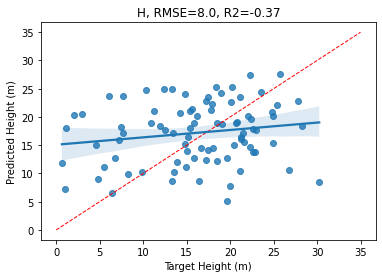

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

plot_regression(y_val.squeeze().numpy(), y_pred.squeeze().detach().numpy())

In [35]:
batch_size = 8
y_pred_train = torch.vstack([model(inp.float()) for inp in torch.split(X_train, batch_size)])


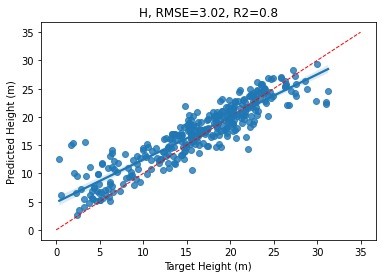

In [36]:
import sklearn.metrics
plot_regression(y_train.squeeze().numpy(), y_pred_train.squeeze().detach().numpy())

In [37]:
data_dir = "/data/RepreSent/UC5"
dm = UC5ForestBiomassDataModule(
    data_dir, batch_size=32, patch_size_px=24, reduce_ts=TimeSeriesReductions.MEAN, 
    training_set_fraction=0.5, seed=42,
)
dm.prepare_data()
dm.setup(stage="test")

test_ds = dm.test_dataset

from tqdm import tqdm

X_test, y_test = [], []
for (s1,s2),y in tqdm(test_ds):
    x = torch.vstack((s2,s1))
    X_test.append(x)
    y_test.append(y)
X_test = torch.stack(X_test)
y_test = torch.stack(y_test)


batch_size = 8
y_pred_test = torch.vstack([model(inp.float()) for inp in torch.split(X_test, batch_size)])


  0%|                                                   | 0/426 [00:00<?, ?it/s]Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
100%|█████████████████████████████████████████| 426/426 [00:28<00:00, 14.97it/s]


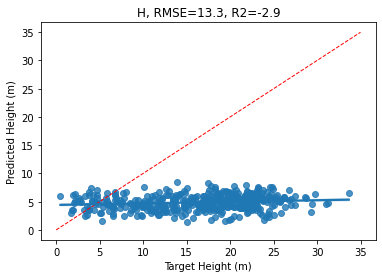

In [39]:

plot_regression(y_test.squeeze().numpy(), y_pred_test.squeeze().detach().numpy())

tensor([17.0800])


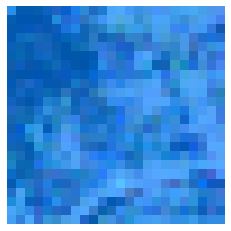

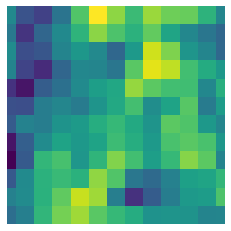

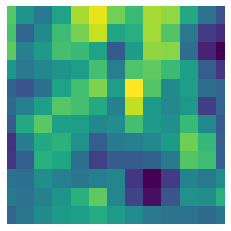

In [31]:
idx = 5

x = X_test[idx]
y = y_test[idx]

from skimage.exposure import equalize_hist
rgb = x[np.array([3,2,1])].numpy()
fig, ax = plt.subplots()
ax.imshow(equalize_hist(rgb).transpose(1,2,0))
ax.axis("off")


fig, ax = plt.subplots()
ax.imshow(x[-1])
ax.axis("off")

fig, ax = plt.subplots()
ax.imshow(x[-2])
ax.axis("off")

print(y)